In [211]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az
from scipy.special import expit

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

In [212]:
df = pandas.read_csv(
    "https://docs.google.com/spreadsheets/d/1AZfxs2caMVdYPsiqiZJmX3P-CTq5Yewi3CAccvT7acw/export?format=csv",
    parse_dates=["end_date"])
df = df[df["pollster"].notnull()].copy()
del df["url"]

df = df.melt(
    id_vars=["pollster", "end_date", "population", "mode", "sample_size", "moe", "kind", "partisan", "Weight"],
    var_name="candidate", value_name="pct")
# df = df[df["pct"].notnull()].copy()

In [213]:
df

pollster   end_date population  \
0               Fairleigh Dickinson 2023-03-06        vap   
1                               GQR 2024-03-12         lv   
2                               GQR 2024-04-12         lv   
3   Renaissance Campaign Strategies 2024-07-14         lv   
4   Renaissance Campaign Strategies 2024-07-14         lv   
..                              ...        ...        ...   
86                  Emerson College 2025-01-21         rv   
87            Public Policy Polling 2025-01-23         lv   
88            Public Policy Polling 2025-01-23         lv   
89               MDW Communications 2025-02-10         lv   
90               MDW Communications 2025-02-10         lv   

                       mode  sample_size   moe           kind  partisan  \
0         phone/text-to-web        808.0  4.60  favourability         0   
1                 voterfile        603.0  4.00  favourability  Sherrill   
2                 voterfile        603.0  4.00          horse  Sherrill   
3                   unknown        902.0  3.46          horse    Baraka   
4                   unknown        902.0  3.46  favourability    Baraka   
..                      ...          ...   ...            ...       ...   
86  phone/text-to-web/panel        437.0  4.60  favourability         0   
87              text-to-web        615.0  4.00  favourability   Spiller   
88              text-to-web        615.0  4.00          horse   Spiller   
89              text-to-web        789.0  3.00          horse    Baraka   
90              text-to-web        789.0  3.00  favourability    Baraka   

    Weight  candidate   pct  
0     0.75     Baraka  17.0  
1     0.50     Baraka  32.0  
2     0.50     Baraka  20.0  
3     0.50     Baraka  12.0  
4     0.50     Baraka  31.0  
..     ...        ...   ...  
86    0.75  Undecided  56.0  
87    0.50  Undecided  28.0  
88    0.50  Undecided  41.0  
89    0.50  Undecided  52.1  
90    0.50  Undecided   0.0  

[91 rows x 11 columns]

In [214]:
df["pct_lower"] = df["pct"] - df["moe"]
df["pct_upper"] = df["pct"] + df["moe"]
df["pct_lower"] = df["pct_lower"].apply(lambda x : 0 if x < 0 else x)

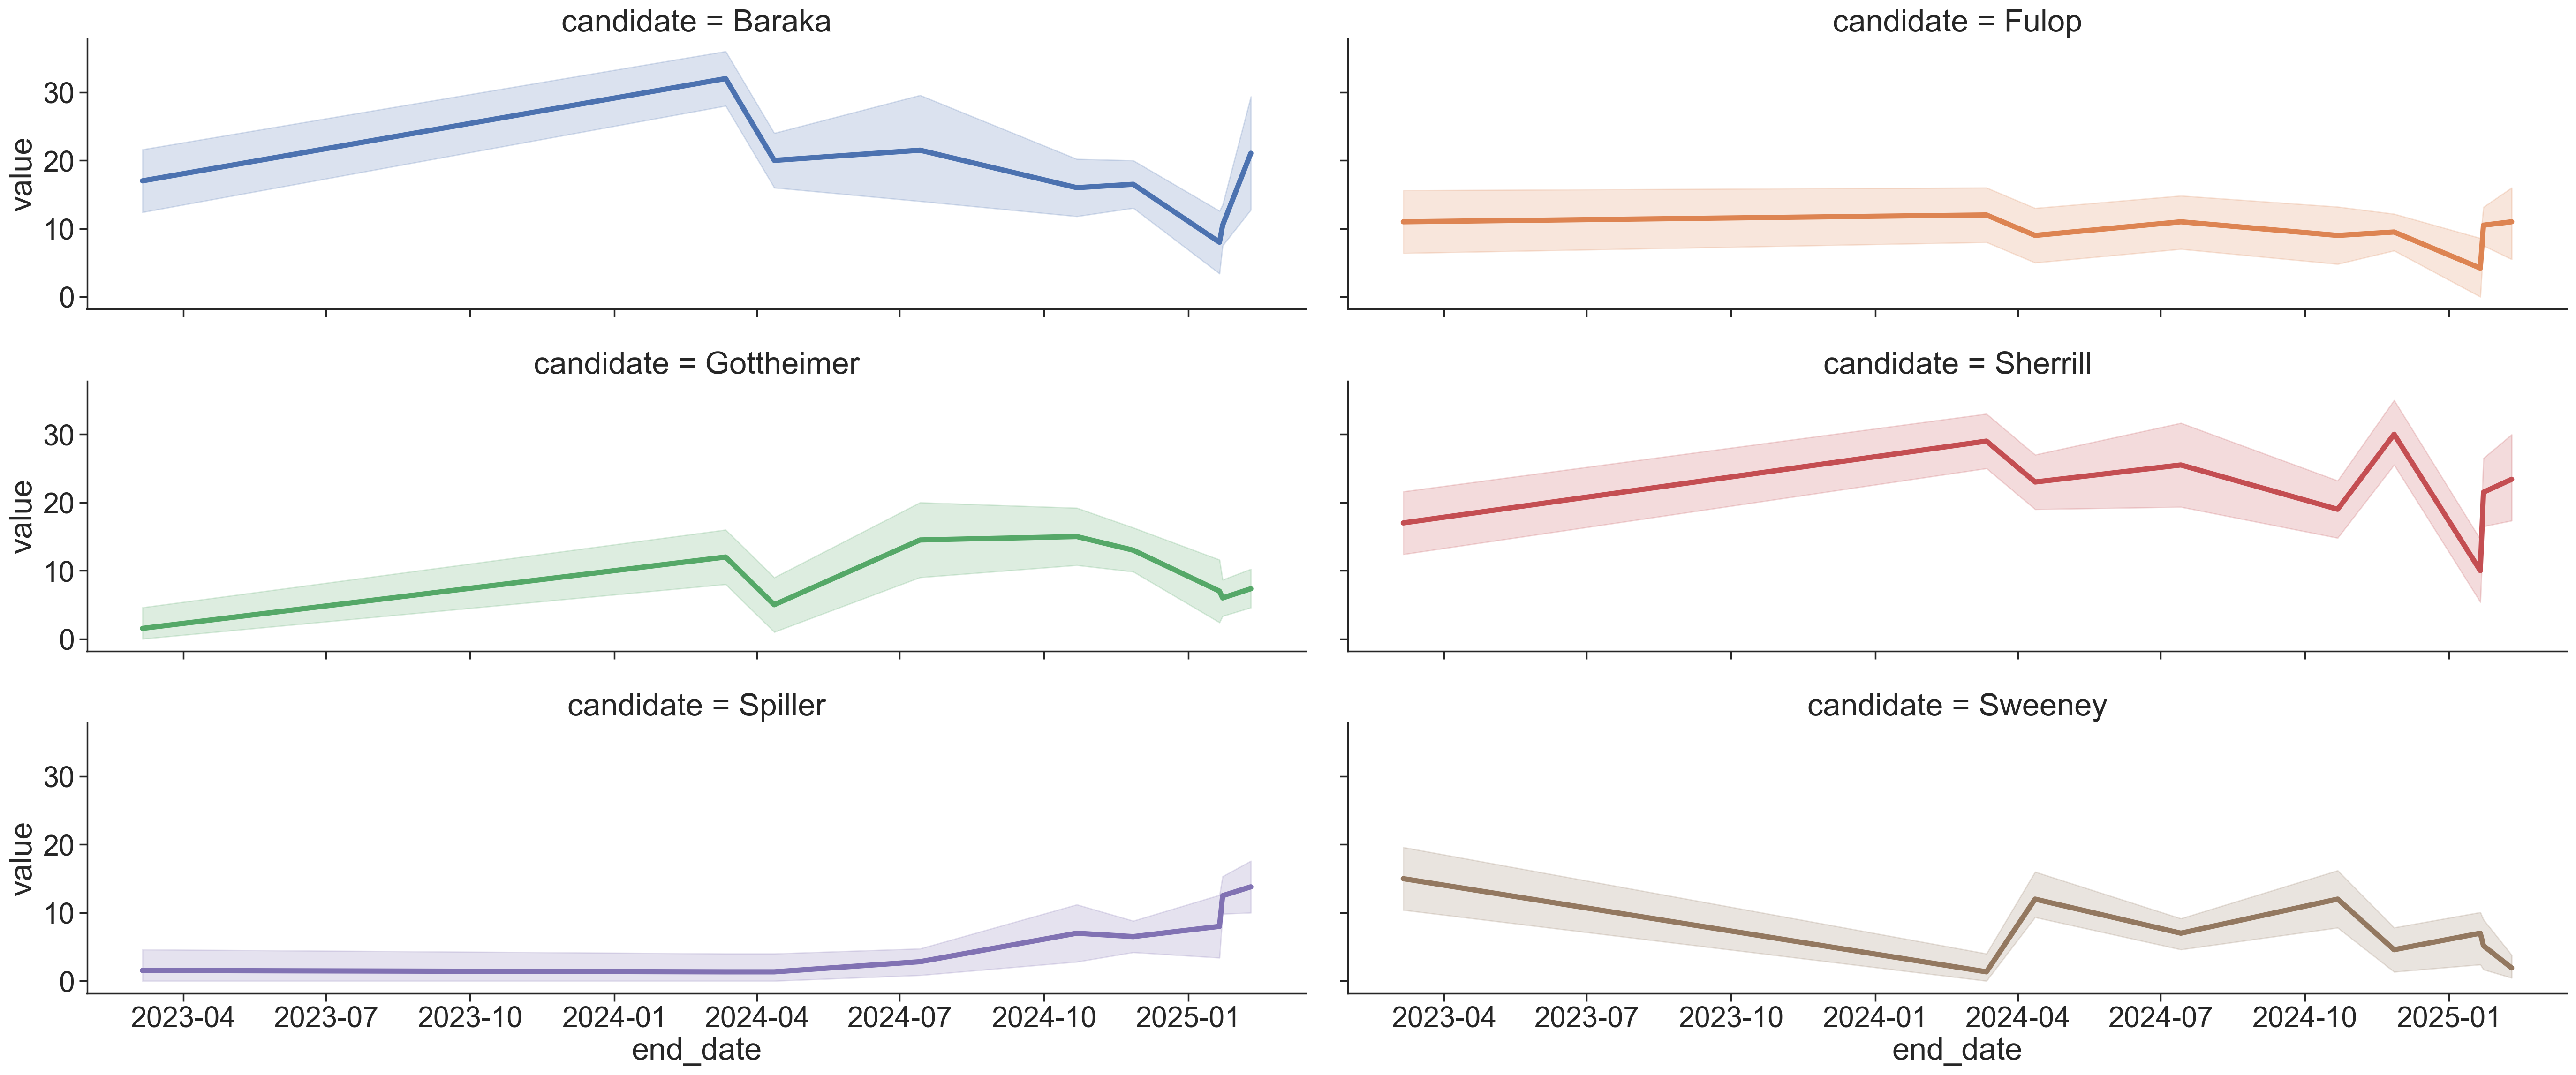

In [215]:
for_plot = df[["end_date", "candidate", "partisan", "pct", "pct_lower", "pct_upper"]].copy()
for_plot = for_plot.melt(id_vars=["end_date", "candidate", "partisan"])

ax = sns.relplot(data=for_plot[for_plot["candidate"] != "Undecided"], x="end_date", y="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="line", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

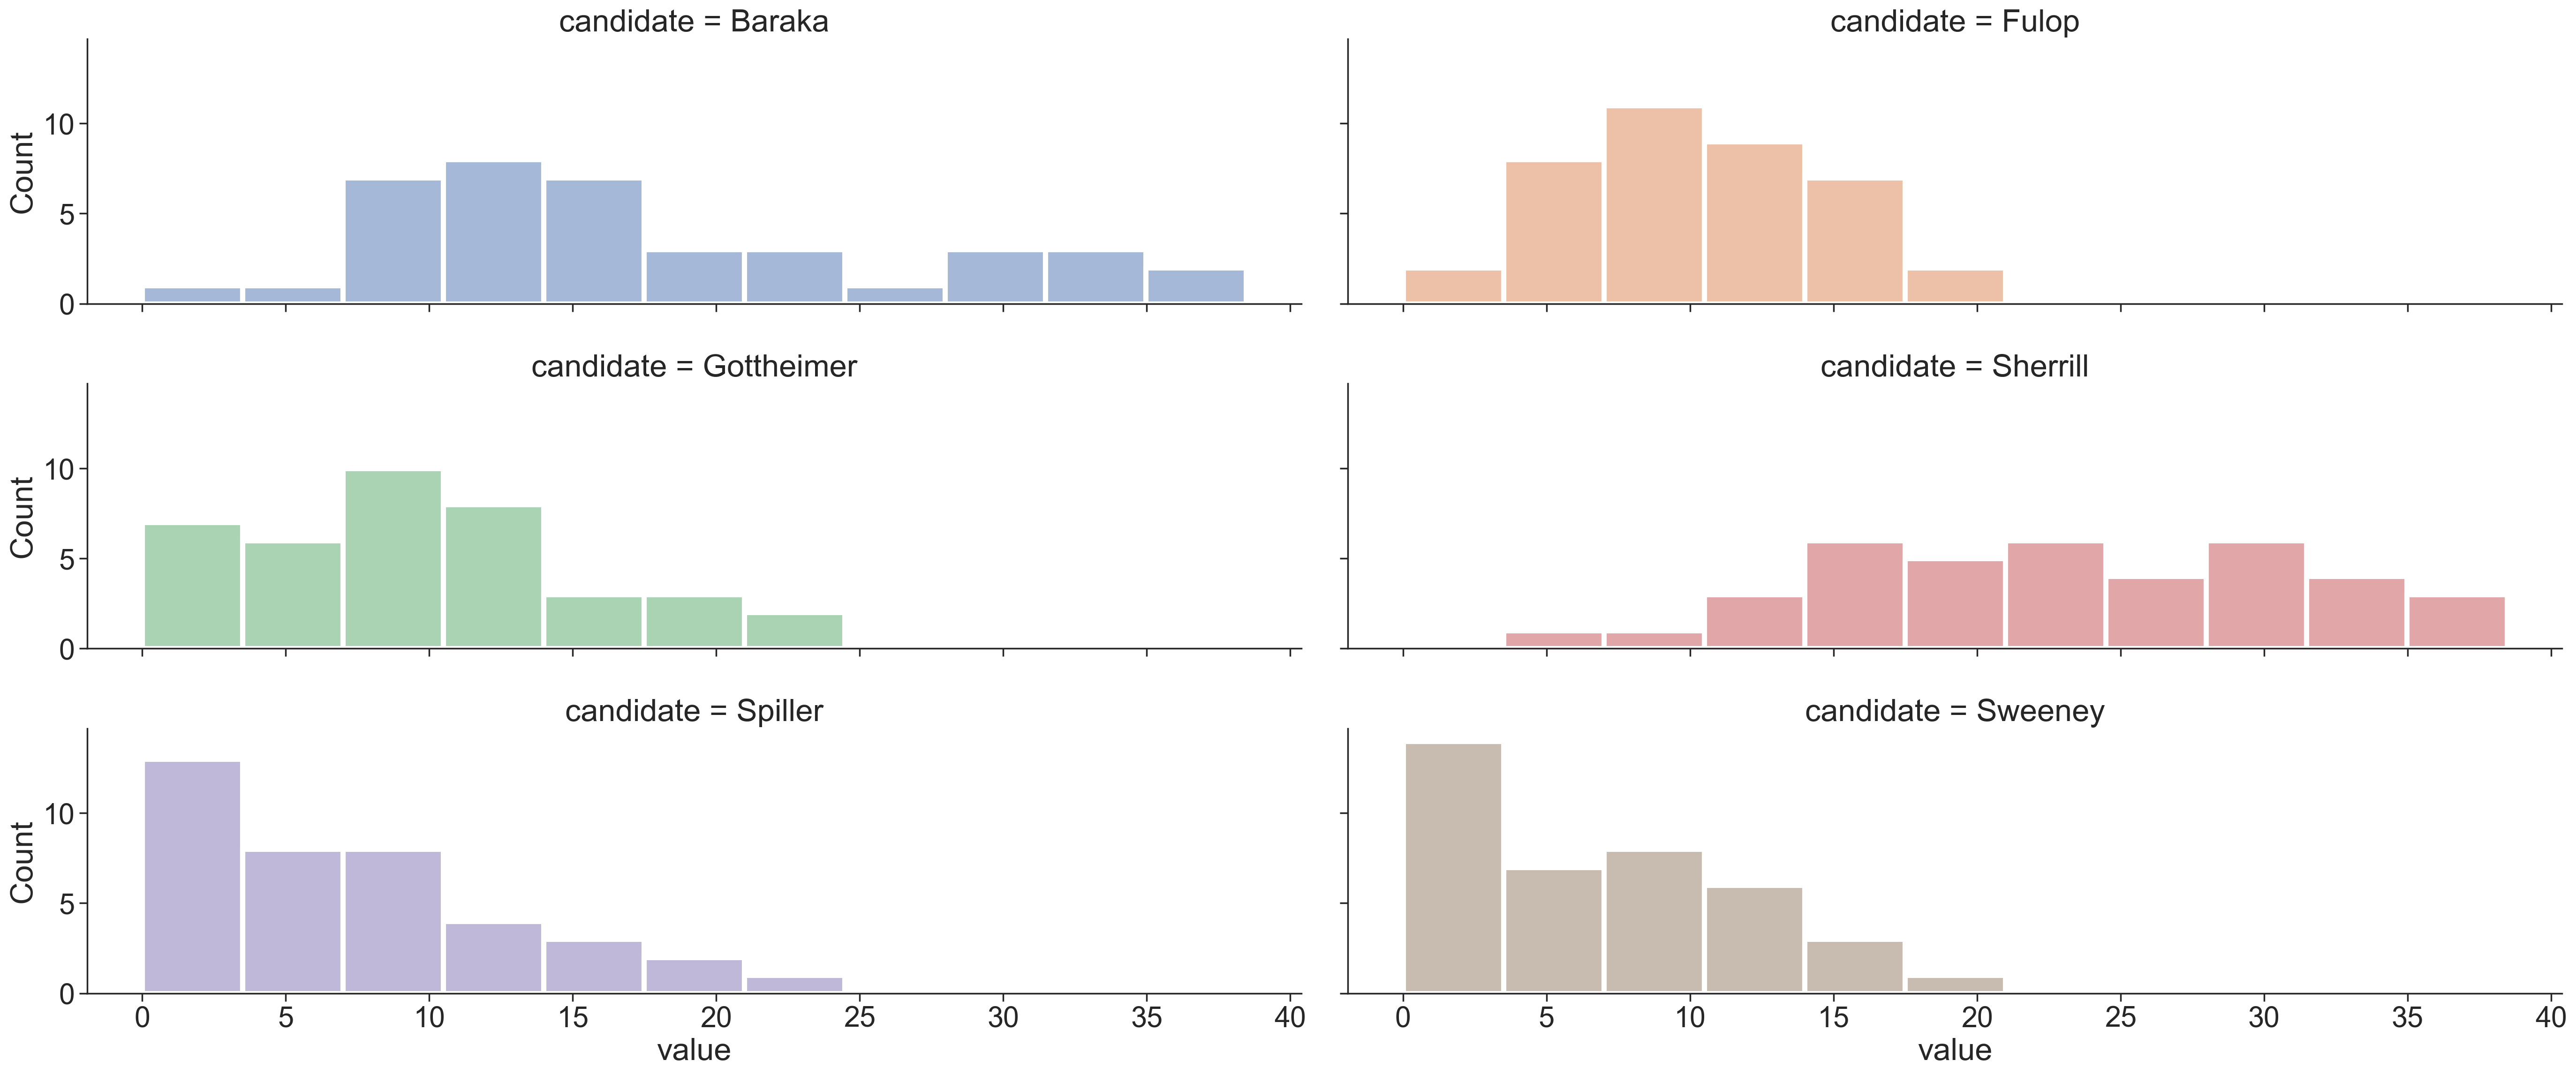

In [216]:
ax = sns.displot(data=for_plot[for_plot["candidate"] != "Undecided"], x="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="hist", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

In [217]:
(for_plot.groupby(["candidate", "partisan"]).agg({"value" : "mean"}).reset_index()
 .pivot(index="candidate", columns="partisan", values="value"))

partisan            0     Baraka        Dem   Sherrill    Spiller
candidate                                                        
Baraka      13.666667  21.275000  16.500000  26.000000  10.500000
Fulop        8.066667  11.000000   9.500000  10.500000  10.500000
Gottheimer   7.844444  10.925000  13.000000   8.500000   6.000000
Sherrill    15.333333  24.450000  30.000000  26.000000  21.500000
Spiller      5.511111   8.310000   6.500000   1.333333  12.500000
Sweeney     11.333333   4.450000   4.576667   6.666667   5.166667
Undecided   39.333333  27.313333  20.500000  23.000000  34.500000

In [218]:
df["num_for"] = ((df["pct"] / 100) * df["sample_size"]).round(0)
df["num_for_lower"] = ((df["pct_lower"] / 100) * df["sample_size"]).round(0)
df["num_for_upper"] = ((df["pct_upper"] / 100) * df["sample_size"]).round(0)

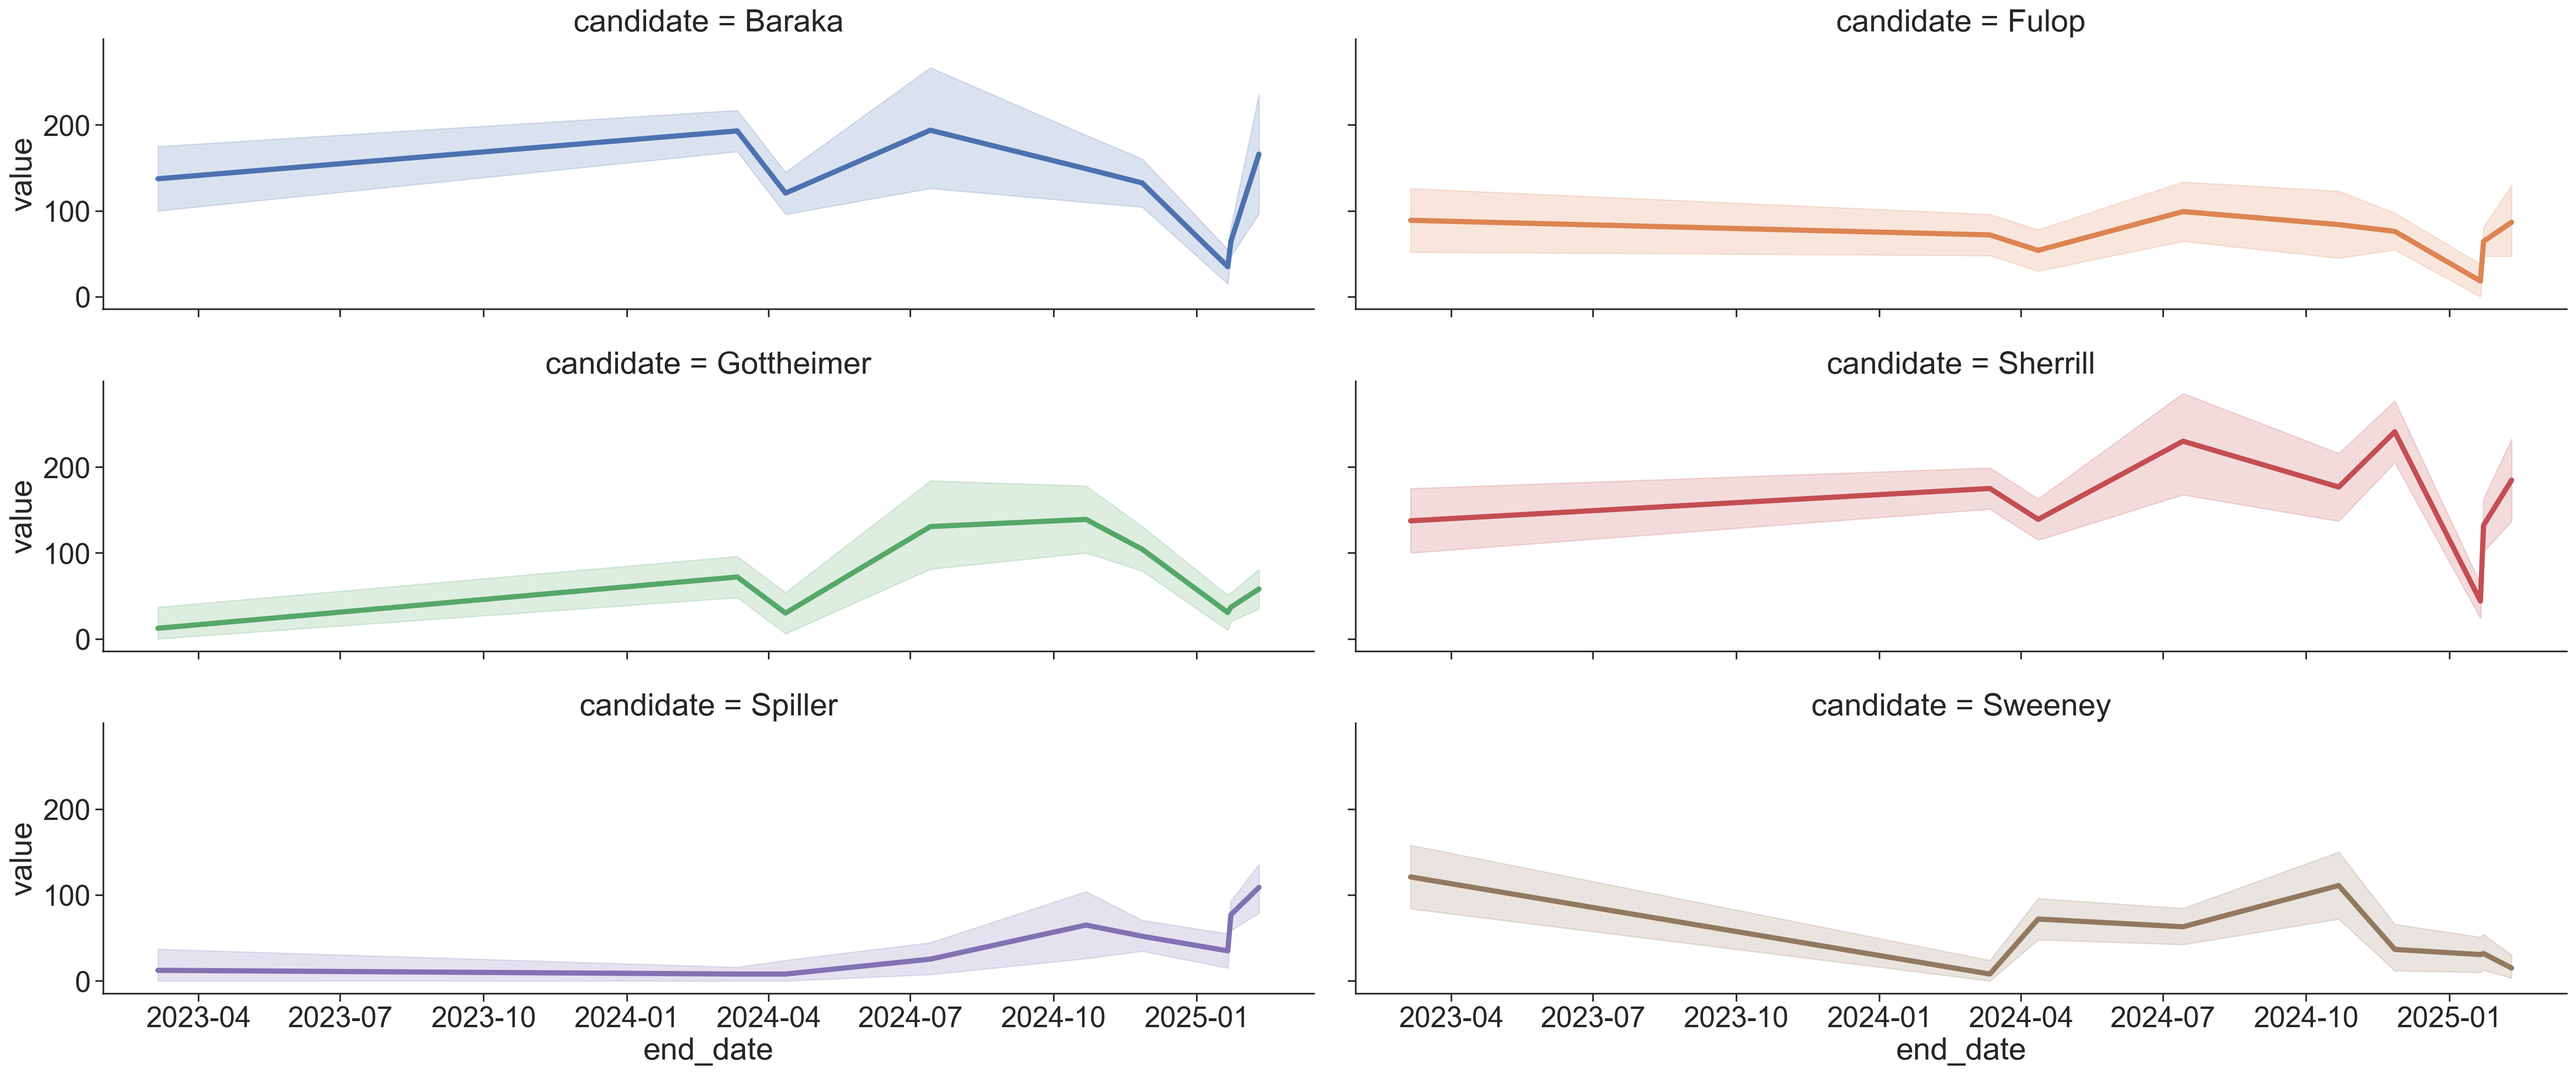

In [219]:
for_plot = df[["end_date", "candidate", "num_for", "num_for_lower", "num_for_upper"]].copy()
for_plot = for_plot.melt(id_vars=["end_date", "candidate"])

ax = sns.relplot(data=for_plot[for_plot["candidate"] != "Undecided"], x="end_date", y="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="line", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

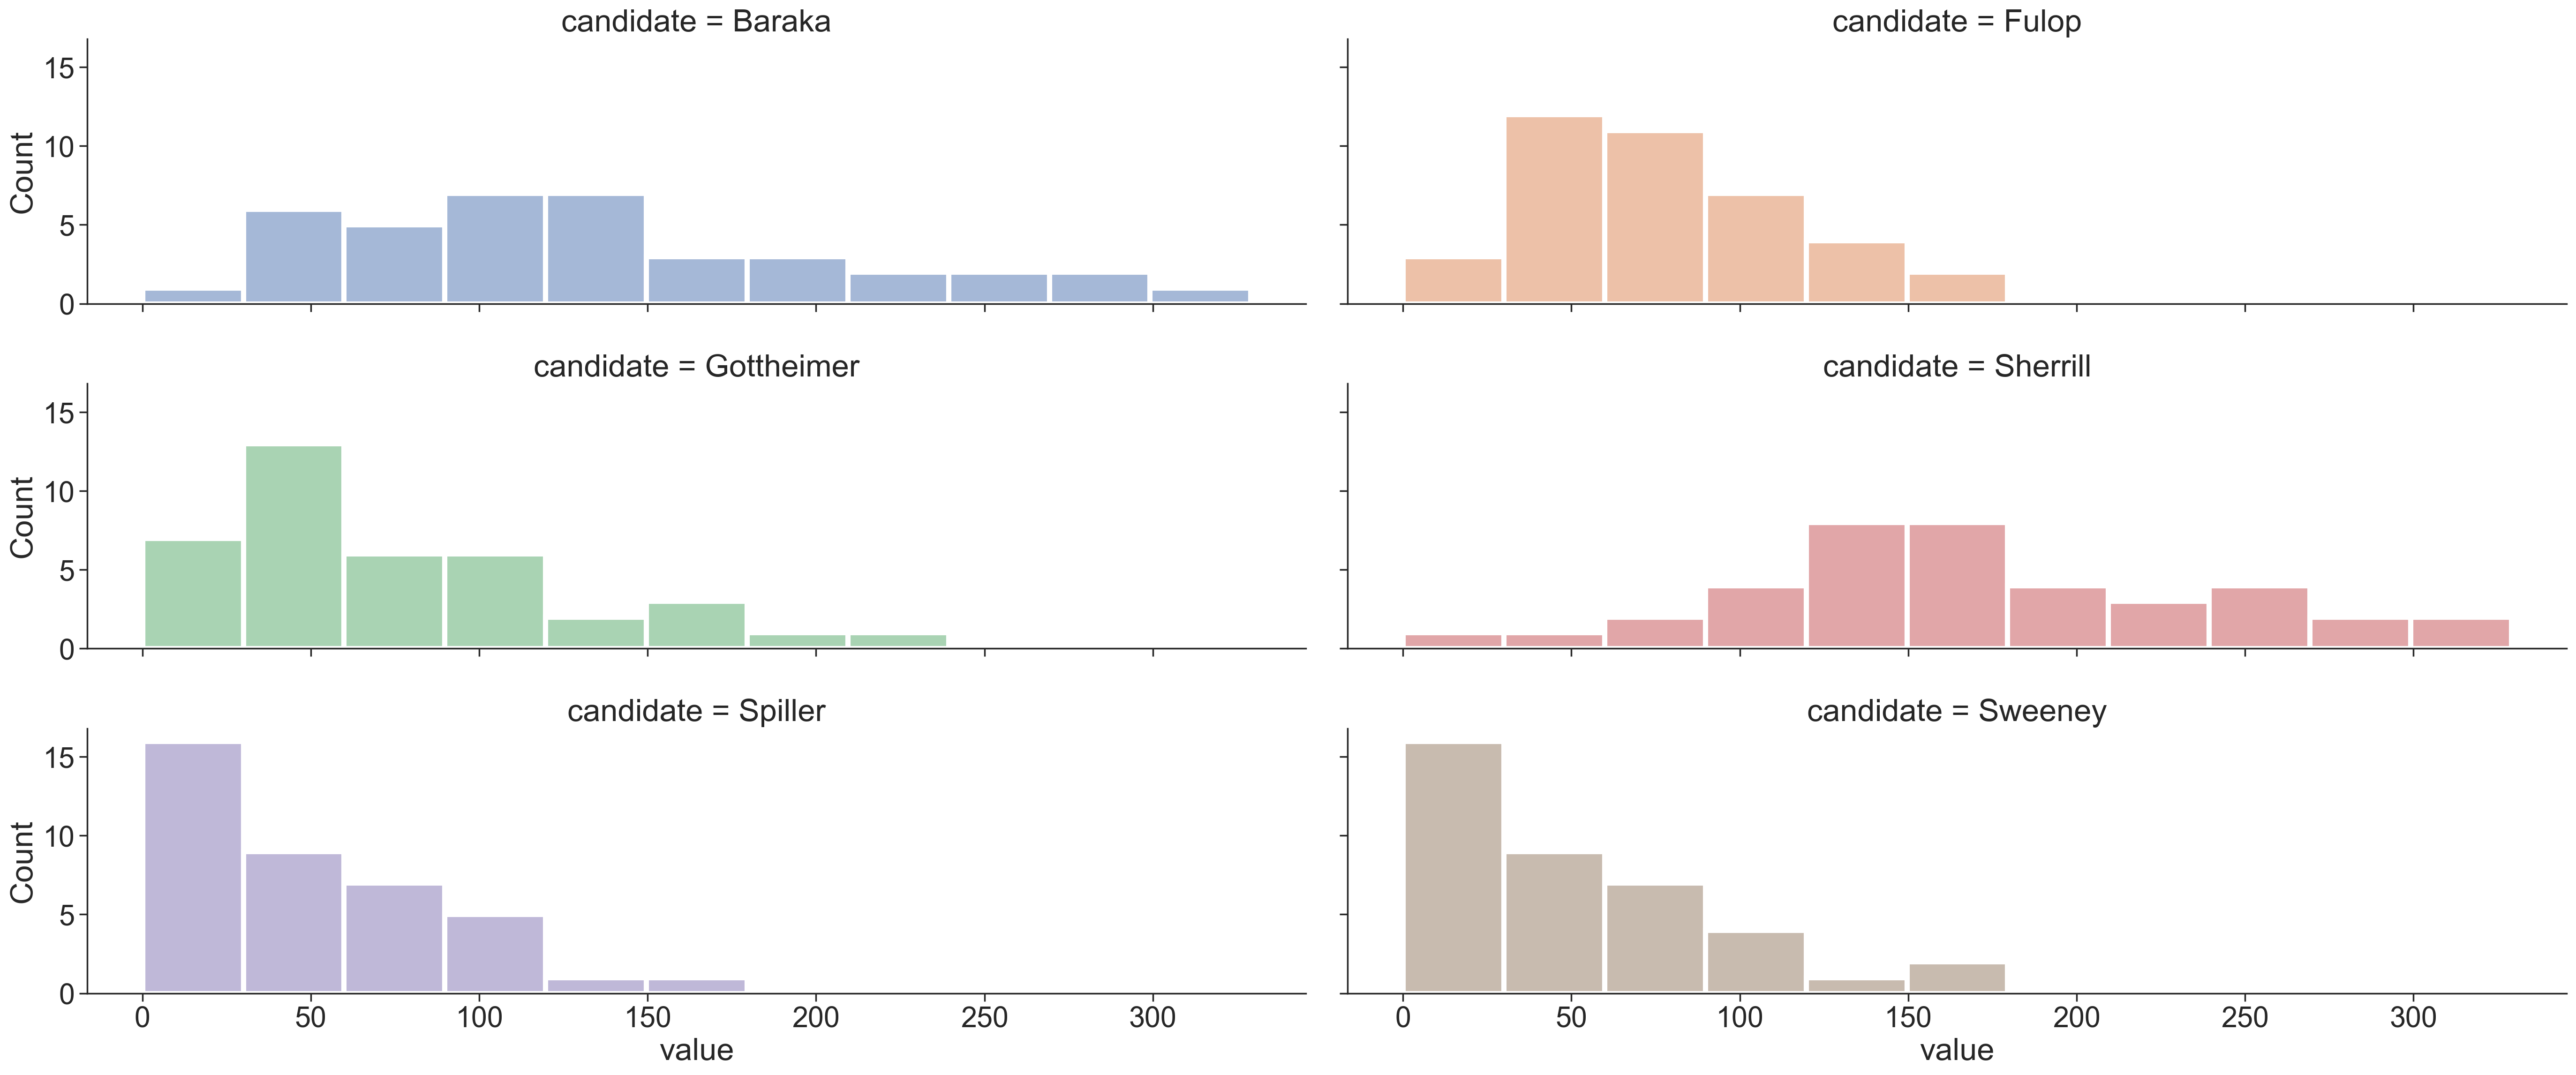

In [220]:
ax = sns.displot(data=for_plot[for_plot["candidate"] != "Undecided"], x="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="hist", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

In [221]:
df["mode"].value_counts()

mode
unknown                    28
text-to-web                28
voterfile                  14
phone/text-to-web           7
panel                       7
phone/text-to-web/panel     7
Name: count, dtype: int64

In [222]:
df["population"].value_counts()

population
lv     70
rv     14
vap     7
Name: count, dtype: int64

---

In [223]:
# based on https://alexandorra.github.io/pollsposition_blog/popularity/macron/hidden%20markov%20models/polls/2021/05/16/hmm-popularity.html

In [224]:
df = df.melt(id_vars=[c for c in df.columns if not c.startswith("num_for")])
df = df.rename(columns={"value" : "num_for"})

In [225]:
cand_id, candidates = df["candidate"].factorize(sort=False)

In [250]:
# kind_id, kinds = df["kind"].factorize(sort=False)

In [251]:
partisan_id, partisans = df["partisan"].factorize(sort=False)

In [252]:
month_id, months = df["end_date"].dt.to_period("M").factorize(sort=False)
months = [str(m) for m in months]

In [253]:
coords = {
    "observation" : df.index,
    "candidate" : candidates,
    "partisan" : partisans,
    "month" : months,
    # "kind" : kinds
}

In [254]:
with pm.Model(coords=coords) as model:
    # kind_effect = pm.Normal("kind_effect", 0, 0.15, dims="kind")
    # partisan_effect = pm.Normal("partisan_effect", 0, 0.15, dims="partisan")
    partisan_effect = pm.Beta("partisan_effect", alpha=2, beta=5, dims="partisan")
    month_effect = pm.Normal("month_effect", 0, 0.15, dims="month")
    shrinkage_pop = pm.HalfNormal("shrinkage_pop", 0.2)
    cand_effect = pm.Normal("candidate_effect", mu=0, sigma=shrinkage_pop, dims="candidate")

    popularity = pm.math.invlogit(partisan_effect[partisan_id] + month_effect[month_id] + cand_effect[cand_id])

    y_hat = pm.Binomial(
        "y_hat",
        p=popularity,
        n=df["sample_size"],
        observed=df["num_for"],
        dims="observation",
    )

In [255]:
with model:
    idata = pm.sample(extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [partisan_effect, month_effect, shrinkage_pop, candidate_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


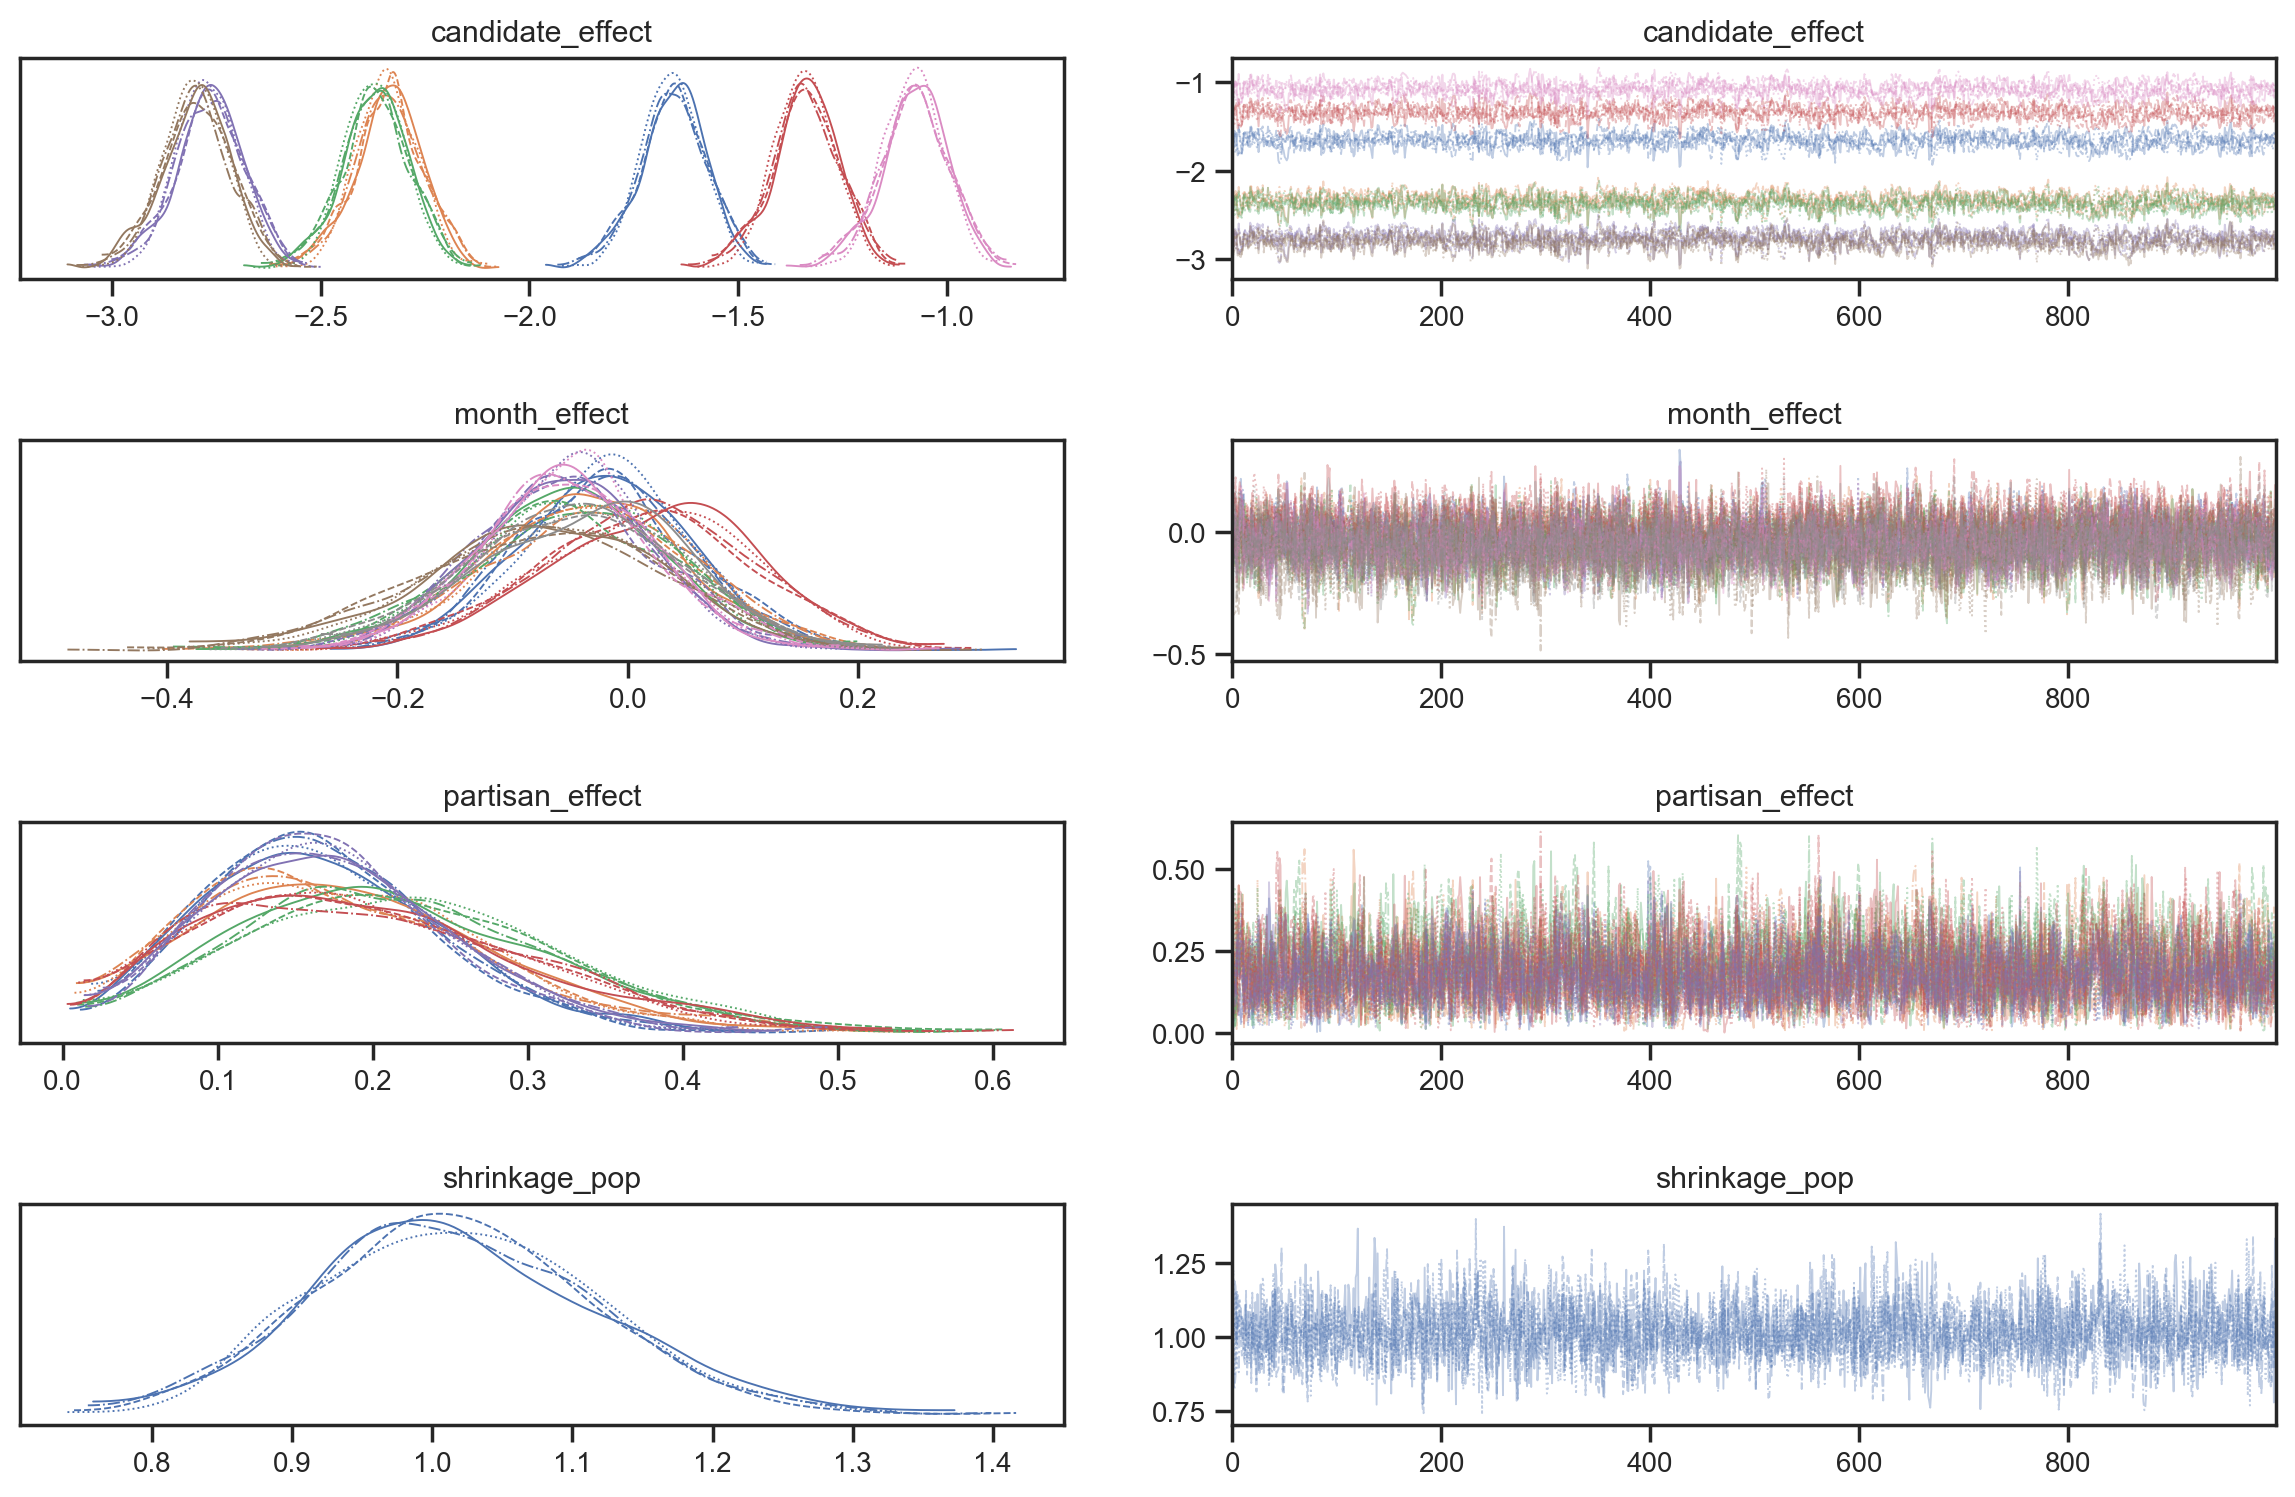

In [256]:
az.plot_trace(idata);
plt.tight_layout()

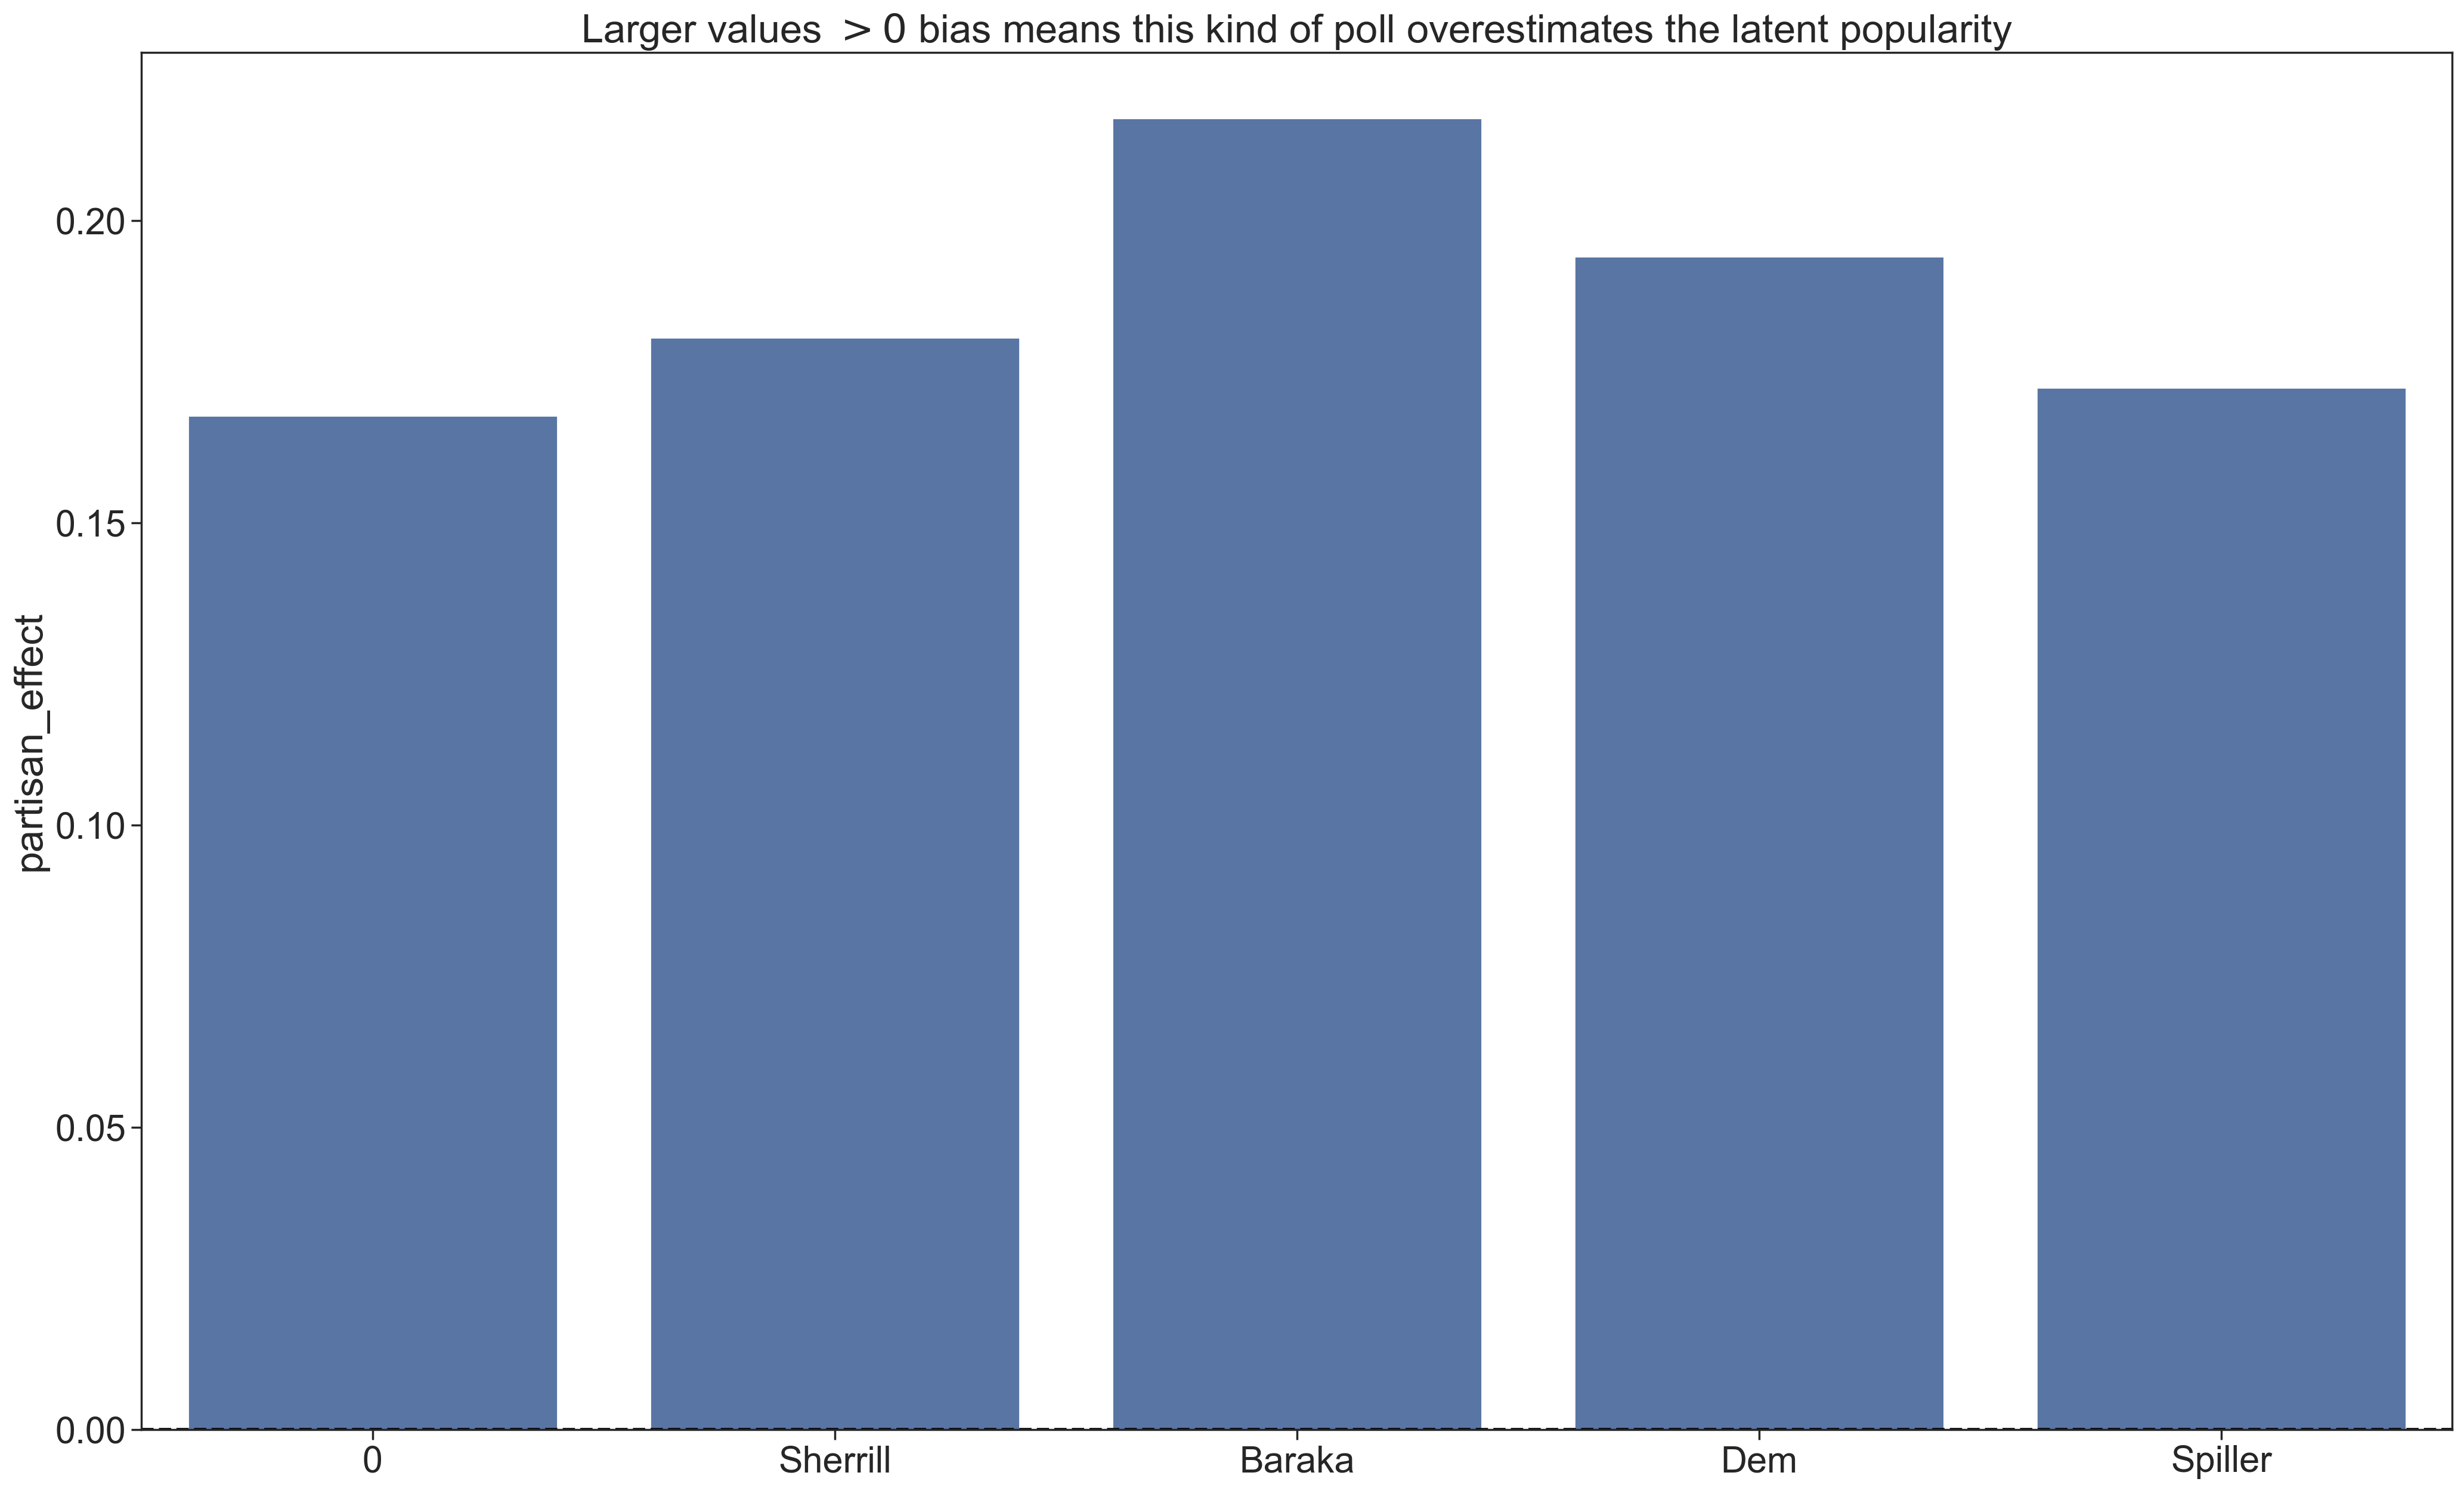

In [257]:
mean_kind_effect = (idata.posterior["partisan_effect"].mean(("chain", "draw")).to_dataframe()).reset_index()
ax = sns.barplot(data=mean_kind_effect, x="partisan", y="partisan_effect")
ax.axhline(0, color="black", linestyle="--", linewidth=2)
ax.set_title("Larger values $>0$ bias means this kind of poll overestimates the latent popularity")
ax.set_xlabel(None)
plt.show()

In [258]:
with model:
    pred_oos = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

In [259]:
cand_preds = {}

for c in idata.posterior.coords["candidate"]:
    post = idata.posterior.sel(candidate=c)
    post_pop = expit(post["partisan_effect"] +
                     post["month_effect"] +
                     post["candidate_effect"]).stack(sample=("chain", "draw"))
    cand_preds[str(c.values)] = dict(zip(post["partisan"].values, post_pop.mean(axis=1).values))

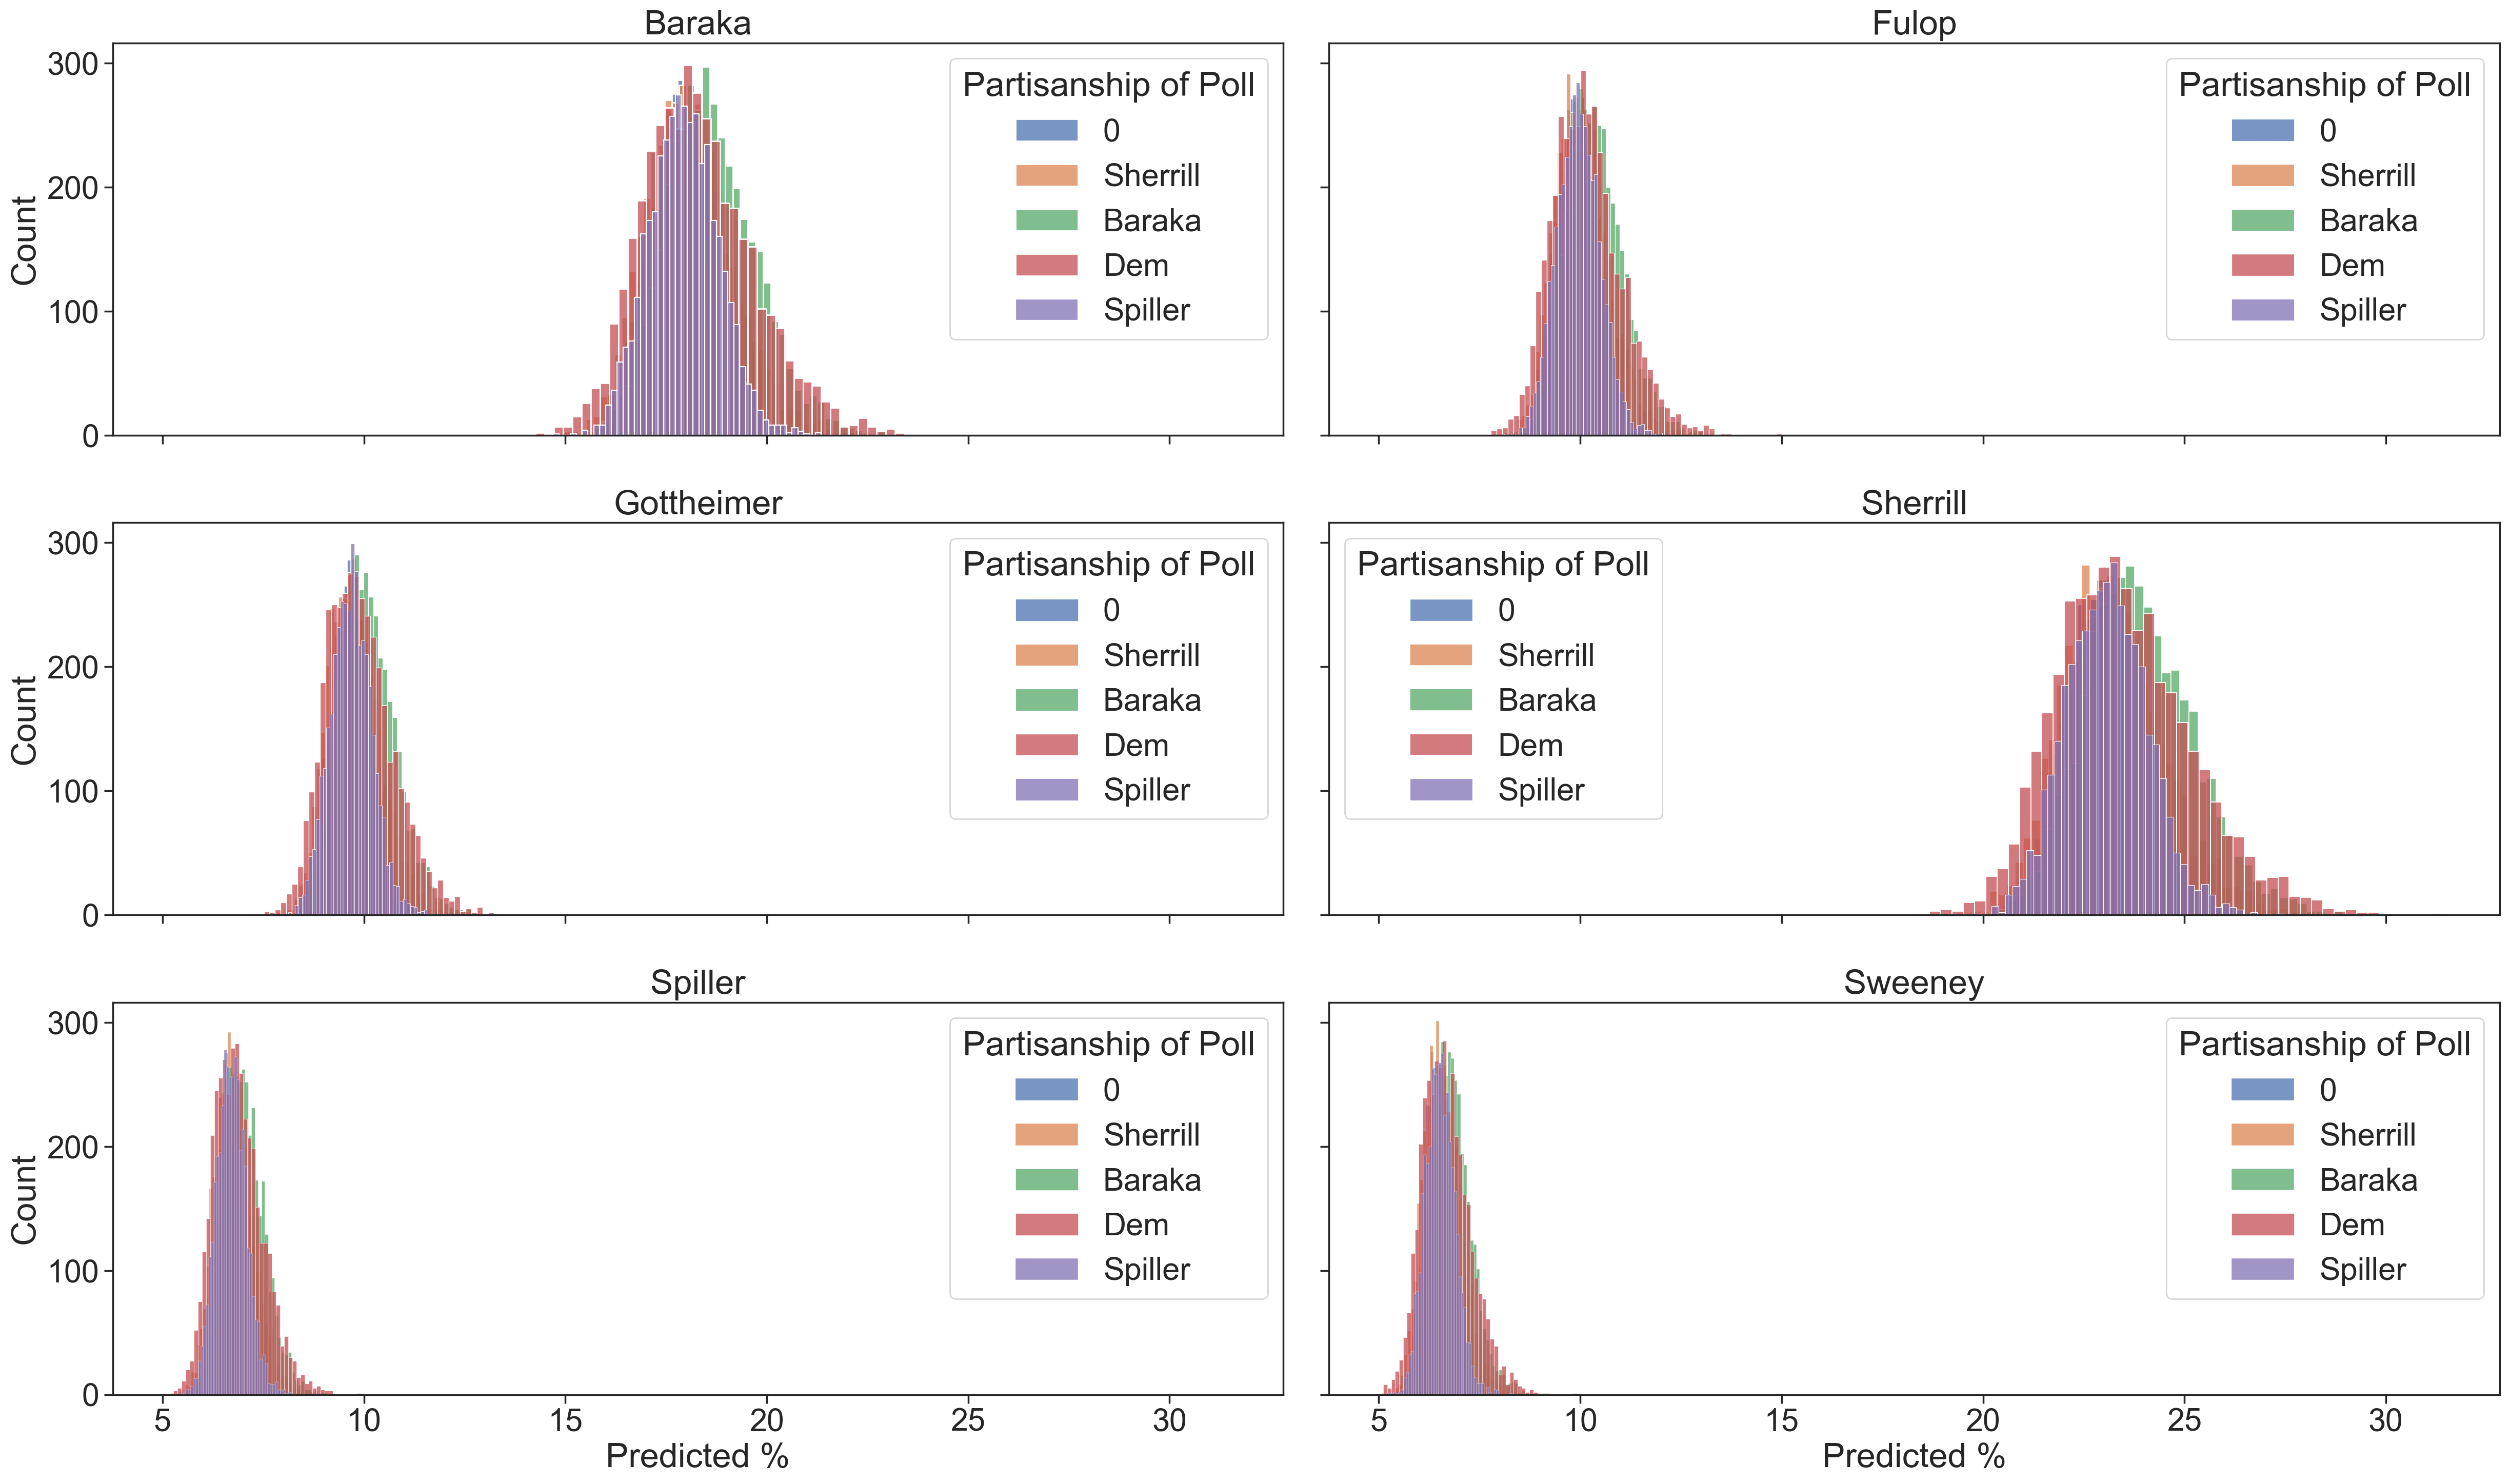

In [264]:
(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True)
for (cand, ax) in zip(cand_preds, axs.ravel()):
    for kind in cand_preds[cand]:
        sns.histplot(x=cand_preds[cand][kind] * 100, label=kind, ax=ax)
    ax.set_title(cand)
    ax.legend(title="Partisanship of Poll")
    ax.set_xlabel("Predicted %")

plt.tight_layout()

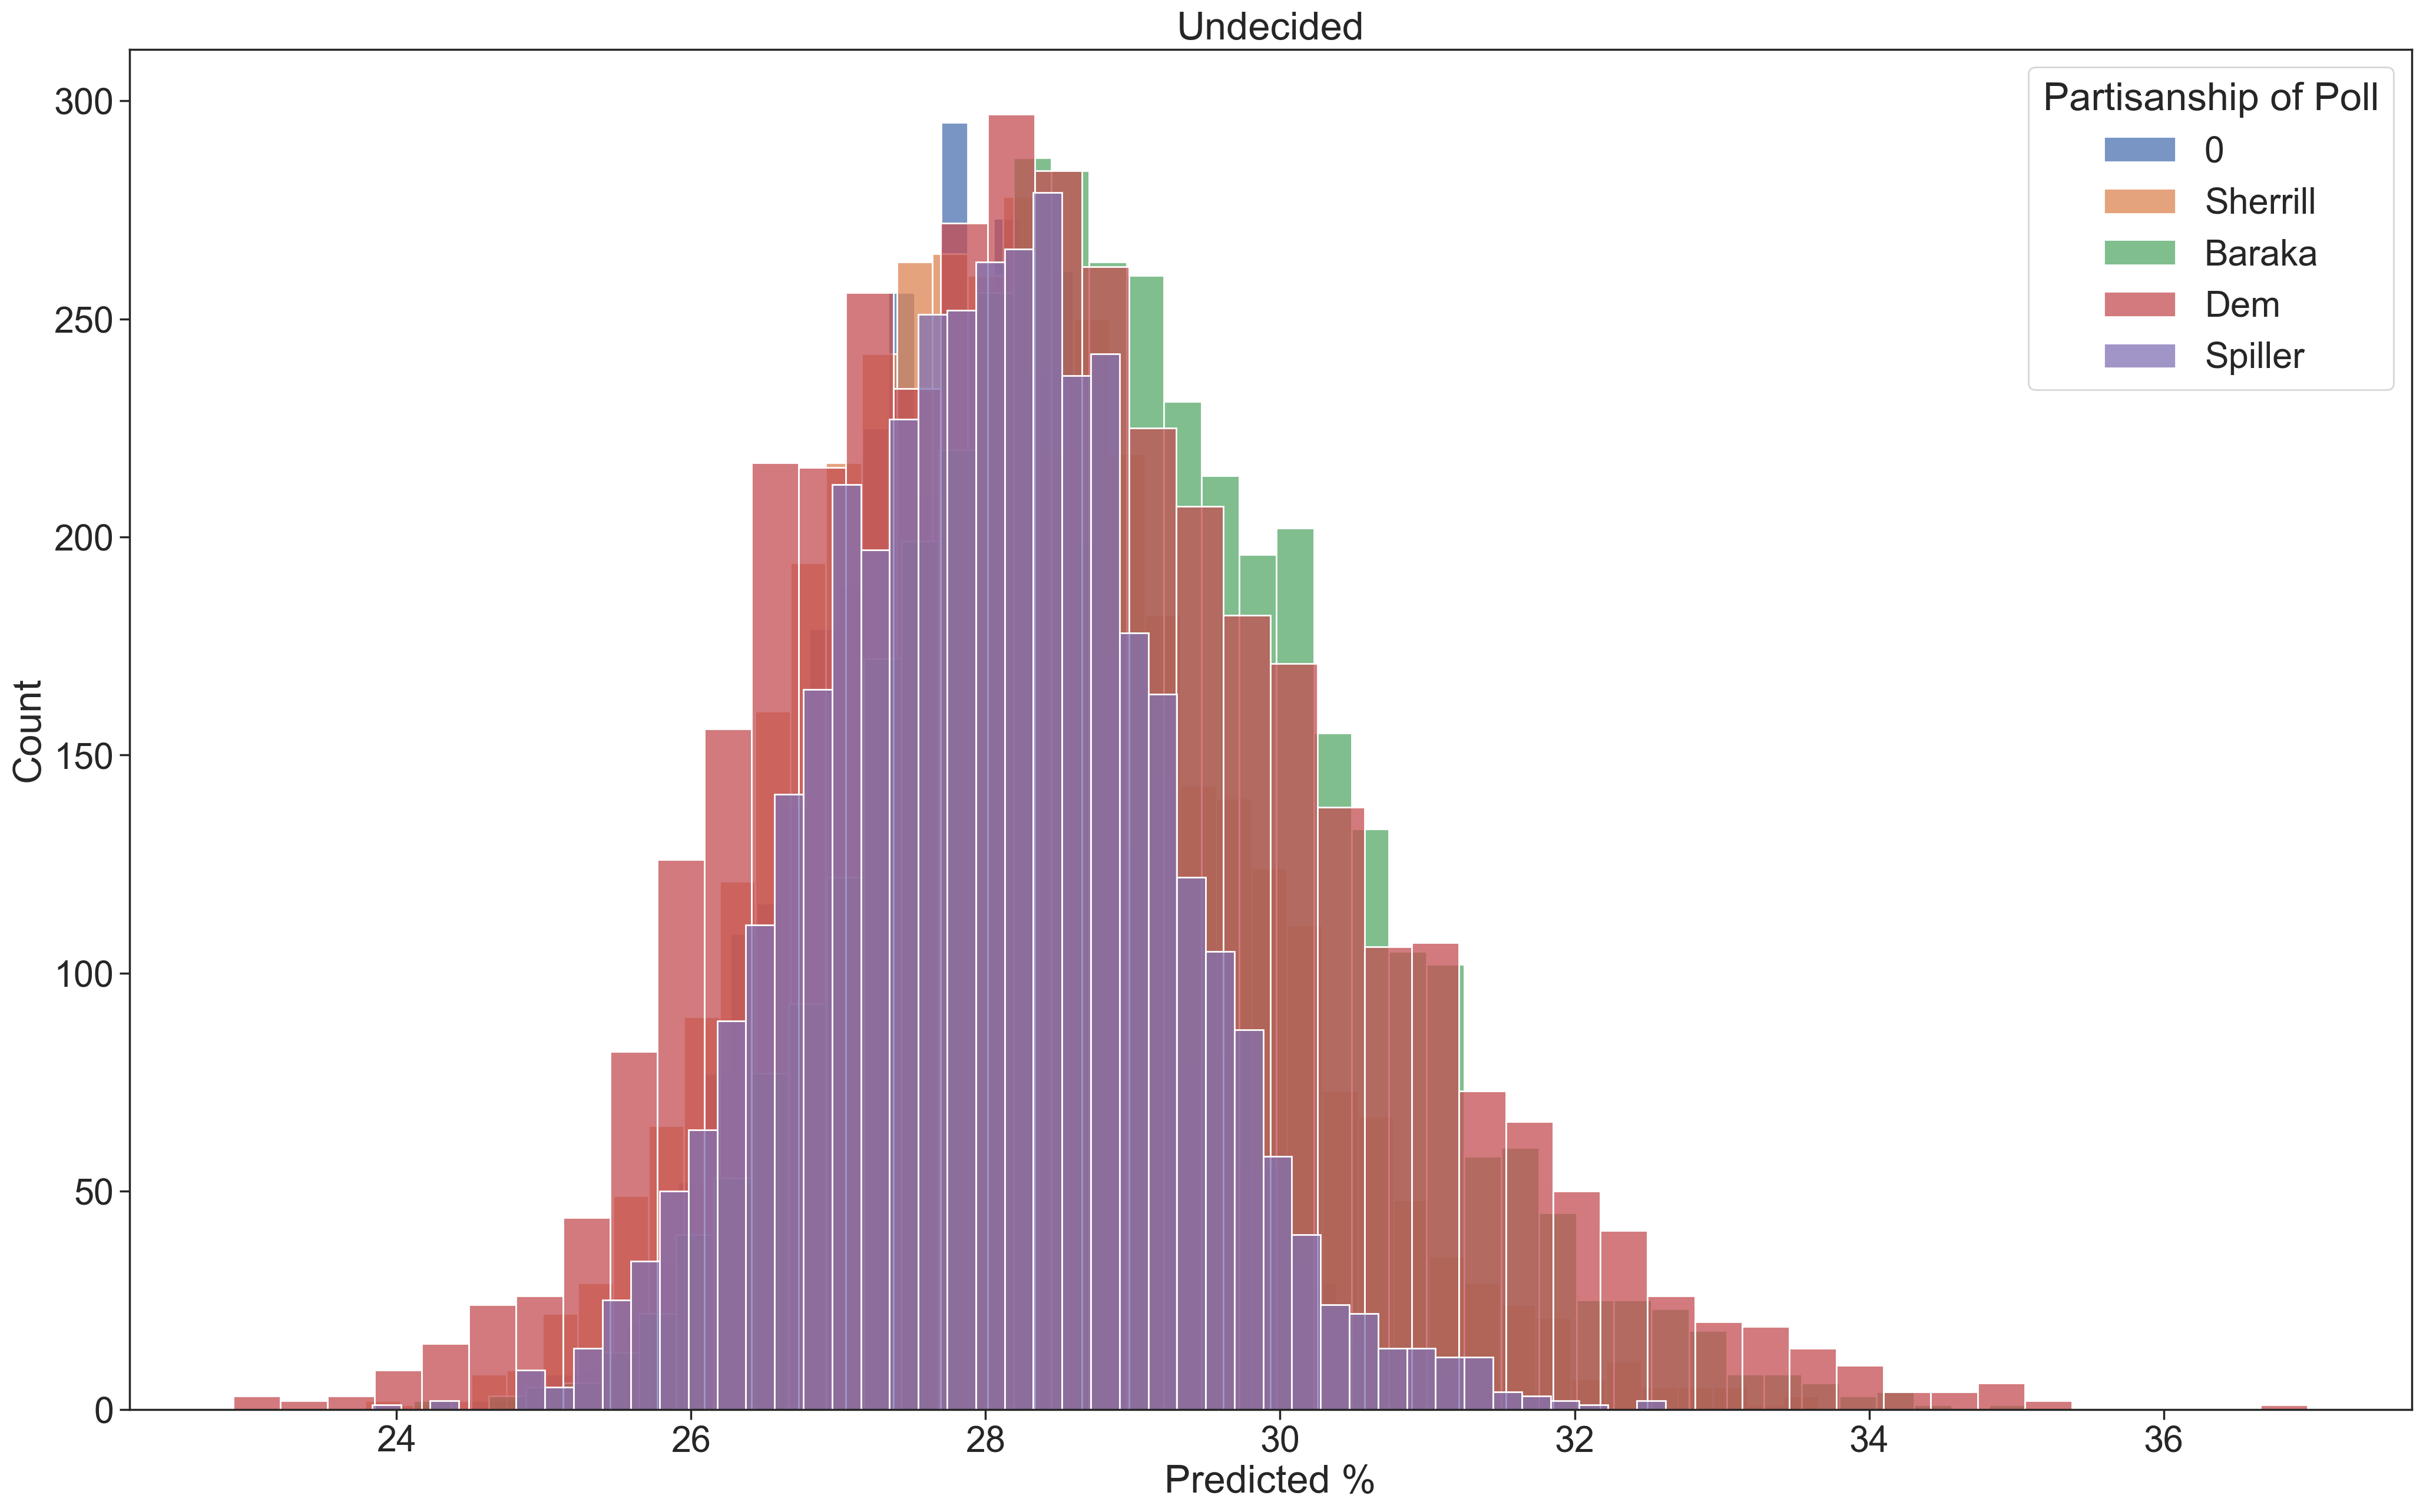

In [261]:
(fig, ax) = plt.subplots(1, 1)
for kind in cand_preds["Undecided"]:
    sns.histplot(x=cand_preds["Undecided"][kind] * 100, label=kind, ax=ax)
ax.set_title("Undecided")
ax.legend(title="Partisanship of Poll")
ax.set_xlabel("Predicted %")
plt.show()

In [262]:
rows = []
for cand in cand_preds:
    x = np.mean(np.stack([cand_preds[cand][k] for k in cand_preds[cand]]), axis=0)
    row = {"Candidate" : cand, "Pred" : np.mean(x), "Lower" : np.quantile(x, 0.025), "Upper" : np.quantile(x, 0.975)}
    rows.append(row)
pred_df = pandas.DataFrame(rows)

In [263]:
pred_df.sort_values(by=["Pred"], ascending=False)

Candidate      Pred     Lower     Upper
6   Undecided  0.283307  0.276900  0.290285
3    Sherrill  0.233336  0.227557  0.239849
0      Baraka  0.181616  0.176313  0.187083
1       Fulop  0.100853  0.096929  0.104880
2  Gottheimer  0.098108  0.094313  0.102090
4     Spiller  0.068120  0.065070  0.071313
5     Sweeney  0.066153  0.063078  0.069512